In [9]:
######################################################################
# Semi-Supervised Classification of Graph Nodes using Exponential Decay
# L42: Assessment 2
# Jan Ondras (jo356), Trinity College
######################################################################
# Baseline MLP training, validation and testing, PubMed dataset
#############################################################################################################
# Load data 
#############################################################################################################

import keras
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import time
import os
from gcn.utils import *

dataset_type = 'pubmed'

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(dataset_type)
# G = nx.from_scipy_sparse_matrix(adj)
# print G.number_of_edges()

if dataset_type == 'pubmed':
    N_classes = 3
    N_features = 500
    N_nodes = 19717
    N_edges = 44327 #44338 - incorrect in GCN paper !
#     print adj.toarray().diagonal()[:50], np.sum(adj.toarray().diagonal())
    if (N_classes != y_train.shape[1] or N_features != features.shape[1] or N_nodes != features.shape[0] 
            or N_edges != (np.sum(adj.toarray().diagonal()) + np.sum(adj.todense()))/2. ):
#         print y_train.shape[1], features.shape[1], features.shape[0]
        raise ValueError("Dataset dimensions differ from expected!")
else:
    raise ValueError("Dataset not supported!")
print dataset_type, "dataset:", "#classes =", N_classes, ", #features =", N_features, ", #nodes =", N_nodes, ", #edges =", N_edges

X_train = features[train_mask].toarray()
X_val = features[val_mask].toarray()
X_test = features[test_mask].toarray()
y_train = y_train[train_mask]
y_val = y_val[val_mask]
y_test = y_test[test_mask]

print "Feature set shapes (train, valid, test):", X_train.shape, X_val.shape, X_test.shape
print "Labels shapes (train, valid, test):", y_train.shape, y_val.shape, y_test.shape
print y_train.shape[0]*100./N_nodes, y_val.shape[0]*100./N_nodes, y_test.shape[0]*100./N_nodes

pubmed dataset: #classes = 3 , #features = 500 , #nodes = 19717 , #edges = 44327
Feature set shapes (train, valid, test): (60, 500) (500, 500) (1000, 500)
Labels shapes (train, valid, test): (60, 3) (500, 3) (1000, 3)
0.304305928894 2.53588274078 5.07176548156


In [ ]:
# Show graph of the network
G = nx.from_scipy_sparse_matrix(adj)
# pos = nx.spring_layout(G)
plt.figure(figsize=(15,15))
nx.draw(G, node_size=5)
plt.show()

In [2]:
#############################################################################################################
# Baseline MLP, validate, DONE
#############################################################################################################
# Tune #hidden layers and #hidden units (same for each layer)
# Dropout fixed

epochs = 10000
train_batch_size = len(X_train)
val_batch_size = len(X_val)
test_batch_size = len(X_test)

N_runs = 100
dropout = 0.5

N_hl_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # range of numbers of hidden layers
N_hu_range = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80] # range of numbers of units per hidden layer
print "Validation over ", len(N_hl_range) * len(N_hu_range), "=", len(N_hl_range), "x", len(N_hu_range), "parameter settings"
vals = np.zeros((len(N_hl_range), len(N_hu_range)))
vals_std = np.zeros((len(N_hl_range), len(N_hu_range)))

for a, N_hl in enumerate(N_hl_range):
    for b, N_hu in enumerate(N_hu_range):
        st = time.time()
        # Create model
        model = Sequential()
        model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
        model.add(Dropout(dropout))
        for i in range(1, N_hl):
            model.add(Dense(N_hu, activation='relu', kernel_initializer='he_uniform'))
            model.add(Dropout(dropout))
        model.add(Dense(N_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        #print model.summary()
        early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

        vals_actual = []
        for i in range(N_runs):
            model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
                       validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

            vals_actual.append( model.evaluate(X_val, y_val, batch_size=val_batch_size, verbose=0)[1] )

        vals[a][b] = np.mean(vals_actual)
        vals_std[a][b] = np.std(vals_actual)
        print "Time taken: ", time.time()-st, (time.time()-st)/60. 
# Total ~ 1.5 hod

Validation over  150 = 10 x 15 parameter settings
Time taken:  27.2242360115 0.453740950425
Time taken:  25.7964191437 0.429946768284
Time taken:  25.7027921677 0.428388516108
Time taken:  25.2209310532 0.420354851087
Time taken:  26.4522459507 0.440871667862
Time taken:  24.3126301765 0.405219666163
Time taken:  23.4495990276 0.390836481253
Time taken:  25.0217030048 0.417029118538
Time taken:  26.4268131256 0.440454049905
Time taken:  28.0802140236 0.468004230658
Time taken:  25.077064991 0.417954047521
Time taken:  27.2800040245 0.45467581749
Time taken:  28.2829911709 0.471387652556
Time taken:  29.4997830391 0.491663682461
Time taken:  27.8080229759 0.463478883108
Time taken:  29.690541029 0.494846832752
Time taken:  29.6721491814 0.494536634286
Time taken:  26.1340692043 0.435568753878
Time taken:  33.5359420776 0.558941316605
Time taken:  32.1135880947 0.535231816769
Time taken:  32.3626439571 0.53941450119
Time taken:  40.1675841808 0.669464584192
Time taken:  33.8087568283 0.5

In [3]:
#############################################################################################################
# Save the results ! IDs 0,1, are used
# TODO save as 1
ID = 0 # zeroth trial, smaller # of hidden sizes
ID = 1 # first ok trial , more # of hidden sizes

if os.path.exists('./../../../Dataset/baseline_' + str(ID) + '_PubMed.npz'):
    raise NameError("Set saveID not in use!")
np.savez('./../../../Dataset/baseline_' + str(ID) + '_PubMed.npz', vals=vals, vals_std=vals_std, 
         N_hl_range=N_hl_range, N_hu_range=N_hu_range, N_runs=N_runs, dropout=dropout, epochs=epochs)

In [2]:
#############################################################################################################
# Load tuned parameters - from Baseline MLP validation on CITESEER dataset
#############################################################################################################

ID = 0 # zeroth trial,  smaller # of hidden sizes
ID = 1 # first ok trial, higher # of hidden sizes

data = np.load('./../../../Dataset/baseline_' + str(ID) + '_PubMed.npz')
vals = data['vals']
vals_std = data['vals_std']
N_hl_range = data['N_hl_range']
N_hu_range = data['N_hu_range']
N_runs = data['N_runs']
dropout = data['dropout']
epochs = data['epochs']

train_batch_size = len(X_train)
val_batch_size = len(X_val)
test_batch_size = len(X_test)

best_N_hl = N_hl_range[np.argmax(vals) // len(N_hu_range)]
best_N_hu = N_hu_range[np.argmax(vals) % len(N_hu_range)]

print "# hidden layers range", N_hl_range
print "# hidden units range", N_hu_range
print "Optimal number of hidden layers: ", best_N_hl
print "Optimal number of hidden units: ",  best_N_hu
print "Best validation accuracy: ", np.max(vals), vals[np.argmax(vals) // len(N_hu_range), np.argmax(vals) % len(N_hu_range)], vals.shape, np.argmax(vals)
print "dropout", dropout, "\tN_runs", N_runs

# hidden layers range [ 1  2  3  4  5  6  7  8  9 10]
# hidden units range [10 15 20 25 30 35 40 45 50 55 60 65 70 75 80]
Optimal number of hidden layers:  2
Optimal number of hidden units:  20
Best validation accuracy:  0.695440005958 0.695440005958 (10, 15) 17
dropout 0.5 	N_runs 100


0.695440005958


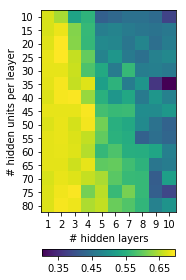

Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)


In [8]:
vmin= np.min(vals)
vmax = np.max(vals)
# mid_val = 0.15
# cmap = 'hot_r' #'coolwarm'
print vmax
# vmax = 0.695440005958
# vmin = 0.0842999996617

plt.figure()
plt.imshow(vals.T) # , vmax = 0.6 , cmap=cmap
plt.xticks(range(len(N_hl_range)), N_hl_range)
plt.yticks(range(len(N_hu_range)), N_hu_range)
plt.xlabel('# hidden layers')
plt.ylabel('# hidden units per leayer')
plt.colorbar(orientation="horizontal", fraction=0.027, ticks=[0.35, 0.45, 0.55, 0.65])
plt.tight_layout()
plt.show()
print "Baseline method: validation accuracy in terms of hidden layer size (x) and number of hidden units per layer (y)"

In [12]:
#############################################################################################################
# Train and Test, again averaged over 100 runs with rand init
#############################################################################################################

# best_N_hl   # from above
# best_N_hu

# Create model
model = Sequential()
model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform', input_dim=N_features))
model.add(Dropout(dropout))
for i in range(1, best_N_hl):
    model.add(Dense(best_N_hu, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout))
model.add(Dense(N_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
print model.summary()
early_stop = EarlyStopping(monitor='val_acc', patience=10, verbose=0) # stop after 10 epochs without improvement in val_acc

test_acc = []
for i in range(N_runs):
    model.fit(X_train, y_train, epochs=epochs, batch_size=train_batch_size, 
               validation_data = (X_val, y_val), verbose=0, callbacks=[early_stop])

    test_acc.append( model.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=0)[1] )

print "Test set accuracy: ", np.mean(test_acc), "+/-", np.std(test_acc)
print "Baseline accuracy (chance level): ", 1./N_classes

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_982 (Dense)            (None, 20)                10020     
_________________________________________________________________
dropout_830 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_983 (Dense)            (None, 20)                420       
_________________________________________________________________
dropout_831 (Dropout)        (None, 20)                0         
_________________________________________________________________
dense_984 (Dense)            (None, 3)                 63        
Total params: 10,503
Trainable params: 10,503
Non-trainable params: 0
_________________________________________________________________
None
Test set accuracy:  0.713900001347 +/- 0.0260911876802
Baseline accuracy (chance level):  0.333333333333


In [ ]:
Using architecture optimised on PubMed dataset

Test set accuracy:  0.713900001347 +/- 0.0260911876802
Baseline accuracy (chance level):  0.333333333333
